In [2]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
from matplotlib import cm
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from IPython.display import clear_output

import warnings

In [3]:
warnings.filterwarnings("ignore")

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
food_dir = './products_dataset'

FOOD = [
    'FreshApple', 'FreshBanana', 'FreshMango', 'FreshOrange', 'FreshStrawberry',
    'RottenApple', 'RottenBanana', 'RottenMango', 'RottenOrange', 'RottenStrawberry',
    'FreshBellpepper', 'FreshCarrot', 'FreshCucumber', 'FreshPotato', 'FreshTomato',
    'RottenBellpepper', 'RottenCarrot', 'RottenCucumber', 'RottenPotato', 'RottenTomato'
]

In [6]:
class LabeledDataset():
    def __init__(self, food_dir, food_classes, transform=None):
        self.food_dir = food_dir
        self.food_classes = food_classes
        self.transform = transform
        self.images_paths = []
        self.labels = []

        for cls_name in food_classes:
            class_path = os.path.join(food_dir, cls_name)

            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.images_paths.append(image_path)
                self.labels.append(food_classes.index(cls_name))
        
    def __len__(self):
        return len(self.images_paths)
    
    def __getitem__(self, index):
        image = Image.open(self.images_paths[index]).convert("RGB")
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [8]:
food_dataset = LabeledDataset(food_dir, FOOD, transform=data_transforms)

In [9]:
trainset_len = int(0.8 * len(food_dataset))
testset_len = len(food_dataset) - trainset_len

In [10]:
train_dataset, test_dataset = torch.utils.data.random_split(food_dataset, [trainset_len, testset_len])

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
def show_image(*, sample: torch.Tensor, channel: int = None):
    channels = {
        0: cm.Reds,
        1: cm.Greens,
        2: cm.Blues,
    }
    
    sample = torch.transpose(sample, 0, 2)

    if channel:
        plt.imshow(sample[:, :, channel], cmap=channels[channel])
    else:
        plt.imshow(sample)

In [14]:
sample = next(iter(train_dataloader))[0]

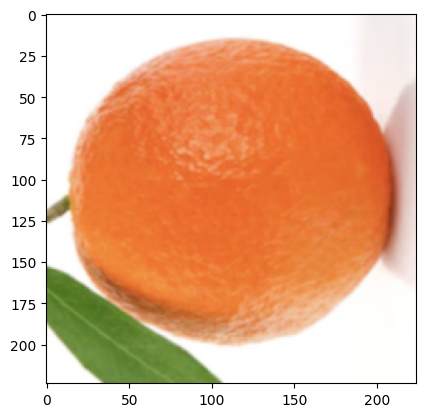

In [92]:
show_image(sample=sample, channel=0)

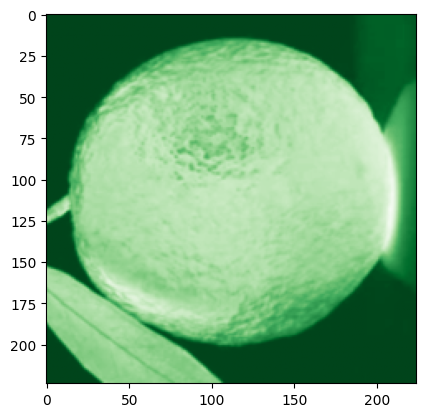

In [93]:
show_image(sample=sample, channel=1)

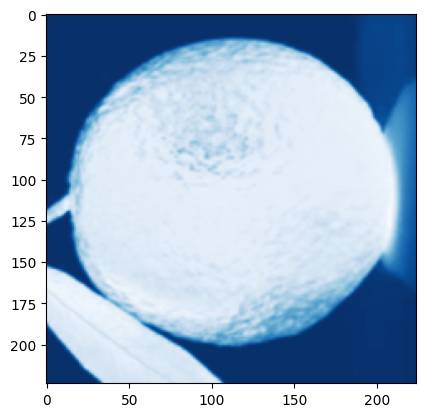

In [94]:
show_image(sample=sample, channel=2)

In [ ]:
images, labels = next(iter(train_dataloader))
images_grid = torchvision.utils.make_grid(images)

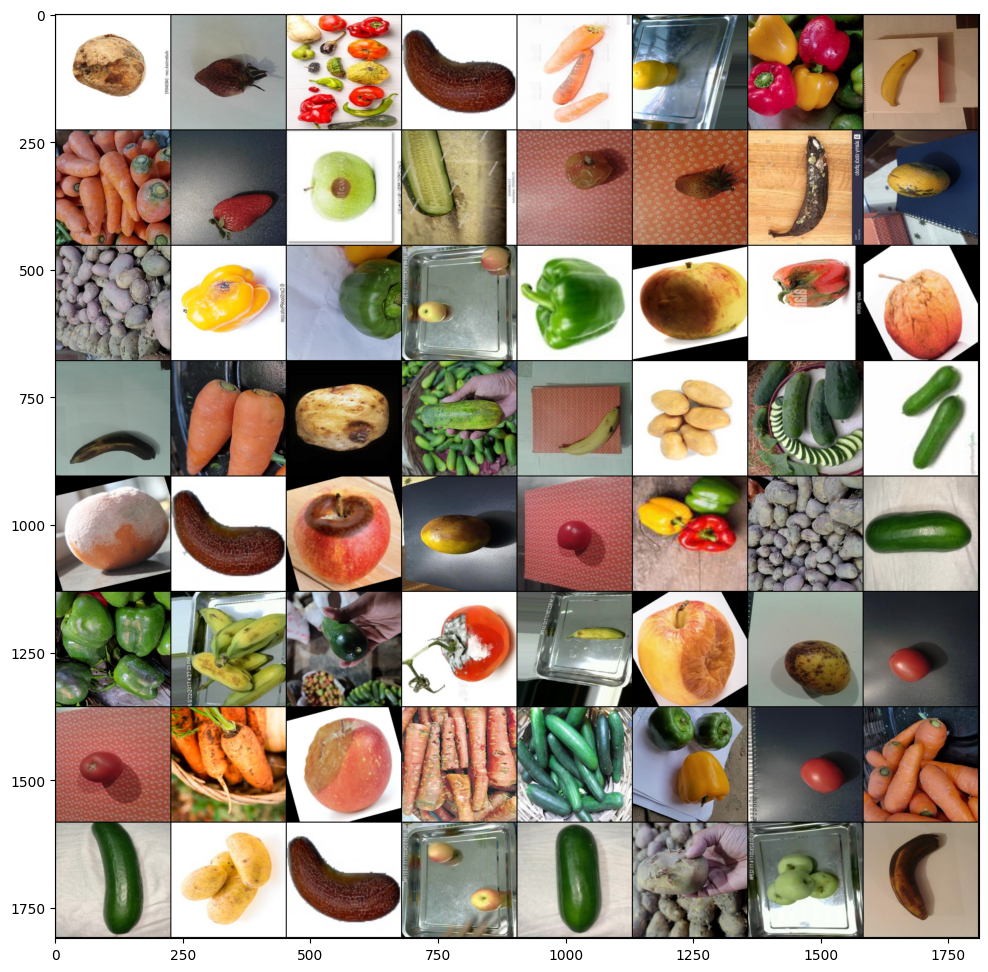

In [98]:
plt.figure(figsize=(12, 12))
show_image(sample=images_grid)

In [13]:
train_samples = 256
val_samples = 64

train_images_list = []
train_labels_list = []
val_images_list = []
val_labels_list = []

for images, labels in test_dataloader:
    val_images_list.append(images)
    val_labels_list.append(labels)

    if sum(len(imgs) for imgs in images) >= val_samples:
        break

all_val_images = torch.cat(val_images_list, dim=0)
all_val_labels = torch.cat(val_images_list, dim=0)

for images, labels in train_dataloader:
    train_images_list.append(images)
    train_labels_list.append(labels)

    if sum(len(imgs) for imgs in images) >= train_samples:
        break

all_train_images = torch.cat(train_images_list, dim=0)
all_train_labels = torch.cat(train_labels_list, dim=0)

In [14]:
small_train_dataset = TensorDataset(all_train_images, all_train_labels)
small_val_dataset = TensorDataset(all_val_images, all_val_labels)

In [15]:
small_train_dataloader = DataLoader(small_train_dataset, batch_size=256, shuffle=True)
small_val_dataloader = DataLoader(small_val_dataset, batch_size=64, shuffle=True)

In [16]:
class BaseLine(nn.Module):
    def __init__(self):
        super(BaseLine, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same')
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same')
        self.fc1 = nn.Linear(in_features=28*28*256, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=20)
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pred = F.relu(self.conv1(x))
        pred = F.relu(self.conv2(pred))
        pred = self.pooling(pred)
        pred = F.relu(self.conv3(pred))
        pred = F.relu(self.conv4(pred))
        pred = self.pooling(pred)
        pred = F.relu(self.conv5(pred))
        pred = F.relu(self.conv6(pred))
        pred = self.pooling(pred)
        pred = nn.Flatten(pred)
        pred = F.relu(self.fc1(pred))
        pred = self.fc2(pred)
    
        return pred

In [18]:
baseline_model = BaseLine().to(device)

In [17]:
def plot_history(train_history, val_history, title):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label='train', zorder=1)

    steps = list(range(0, 1, int(len(train_history) / len(val_history))))

    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel("Train steps")
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [19]:
def train(
        model: nn.Module,
        criterion, 
        optimizer: torch.optim,
        train_data,
        val_data,
        epochs: int
    ):

    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []

    

    for epoch in range(epochs):
        train_epoch_loss = []
        train_epoch_true = []

        model.train()
        
        for images, labels in tqdm(
            train_data,
            desc=f'Train. Epoch: [{epoch}/{epochs}]',
            leave=False
        ):
            images, labels = images.to(device), labels.to(device)

            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_epoch_loss.append(loss.item())
            
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true.append((pred_classes == labels.cpu()).sum())
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))
            train_acc_log.append((pred_classes == labels.cpu()).sum() / labels.cpu().shape[0])

        val_epoch_loss = []
        val_epoch_true = []

        model.eval()

        with torch.no_grad():
            for images, labels in tqdm(
                val_data,
                desc=f'Evaluate. Epoch: [{epoch}/{epochs}]',
                leave=False
            ):
                images, labels = images.to(device), labels.to(device)

                y_pred = model(images)
                loss = criterion(y_pred, labels)
                val_epoch_loss.append(loss.item())

                pred_classes = torch.argmax(y_pred, dim=-1)
                val_epoch_true.append((pred_classes == labels.cpu()).sum())
                val_acc_log.append(pred_classes == labels.cpu().sum() / labels.cpu().shape[0])

        val_loss_log.append(val_epoch_loss.sum() / len(val_epoch_loss))
        val_acc_log.append(val_epoch_true.sum() / val_epoch_true.size(0) / val_data.size(0))   #TODO заменить на batch_size

        clear_output()

        plot_history(train_loss_log, train_acc_log, 'loss')
        plot_history(val_loss_log, val_acc_log, 'accuracy')

        print(f'Train loss: {train_epoch_loss.sum() / len(val_epoch_loss)}')
        print(f'Train accuracy: {train_epoch_true.sum() / len(train_epoch_true) / train_data.size(0)}')   #TODO заменить на batch_size
        print(f'Validation loss: {val_epoch_loss.sum() / len(val_epoch_loss)}')
        print(f'Validation accuracy: {val_epoch_true.sum() / val_epoch_true.size(0) / val_data.size(0)}')   #TODO заменить на batch_size

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=0.001, momentum=0.9)